이번 강의에서는 12장을 다룹니다. Eligibility Trace 역시 다른 강화학습 주제들처럼 개념을 이해하는 것이 중요합니다. 

코드는 지난 시간에 했던 Example 10.1 Mountain Car Task 를 다시 풀 거예요. 코드는 매우 간단하고, p.293의 Semi-gradient TD($\lambda$) for estimating $\hat{v} \approx v_\pi$ 알고리즘이니 교과서를 참고하면 돼요.

문제 구현 방법은 10장에서 구현했던 Mountain Car Task와 동일합니다.  

# 3. Example 10.1 Mountain Car Task 

## 3.1. Problem Definition

In [7]:
import numpy as np

class MountainCarEnv:
    def __init__(self, seed: int | None = None):
        self.x_min, self.x_max = -1.2, 0.5
        self.v_min, self.v_max = -0.07, 0.07
        self.goal_x = 0.5
        self.actions = np.array([-1, 0, +1], dtype=int)  # a ∈ {-1,0,+1}
        self.r_step = -1.0
        self._rng = np.random.RandomState(seed)
        self.state = None  # (x, v)

    def reset(self):
        x0 = self._rng.uniform(-0.6, -0.4)
        v0 = 0.0
        self.state = np.array([x0, v0], dtype=float)
        return self.state.copy()

    def step(self, a_idx: int):
        assert 0 <= a_idx < len(self.actions), "Invalid action index"
        a = float(self.actions[a_idx])

        x, v = self.state
        v_next = v + 0.001 * a - 0.0025 * np.cos(3.0 * x)
        v_next = np.clip(v_next, self.v_min, self.v_max)
        x_next = x + v_next

        if x_next < self.x_min:
            x_next = self.x_min
            v_next = 0.0

        done = x_next >= self.goal_x
        reward = 0.0 if done else self.r_step

        self.state = np.array([x_next, v_next], dtype=float)
        return self.state.copy(), reward, done, {}

    @property
    def n_actions(self) -> int:
        return len(self.actions)

    def sample_action(self) -> int:
        return int(self._rng.randint(self.n_actions))

# 나중에 어차피 쓸 epsilon greedy 함수입니다.
def epsilon_greedy(q_values: np.ndarray, epsilon: float, rng: np.random.RandomState) -> int:
    """
    q_values: shape (n_actions,)
    """
    if rng.rand() < epsilon:
        return int(rng.randint(q_values.shape[0]))
    max_as = np.flatnonzero(q_values == q_values.max())
    return int(rng.choice(max_as))

## Semi-gradient TD($\lambda$) for estimating $\hat{v} \approx v_\pi$ 

교수의 옛날 코드이니 학생들이 직접 수정해 보세요. 
  1. 코드를 이해한다.
  2. 직접 수정해야 할 내용을 찾아 본다. 
  3. 생성형AI의 도움을 받아 제안을 확인한다.
  

TD(lambda): 100%|██████████| 1000/1000 [02:32<00:00,  6.56it/s]


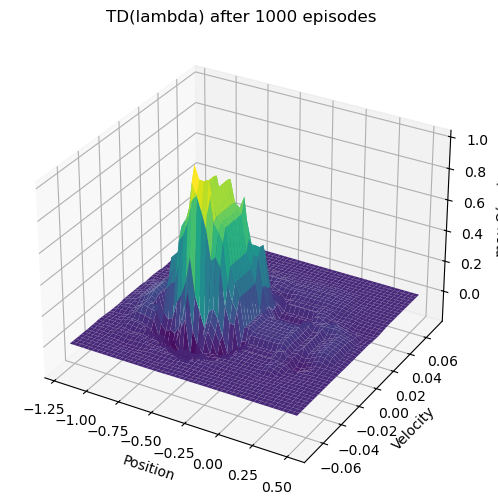

In [9]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

class IHT:
    def __init__(self, size):
        self.size = size
        self.overfull_count = 0
        self.dictionary = {}

    def getindex(self, obj, readonly=False):
        if obj in self.dictionary:
            return self.dictionary[obj]
        elif readonly:
            return None
        if len(self.dictionary) >= self.size:
            return hash(obj) % self.size
        idx = len(self.dictionary)
        self.dictionary[obj] = idx
        return idx


def tiles(iht, num_tilings, floats, ints=None):
    if ints is None:
        ints = []
    coords = []
    qfloats = [f * num_tilings for f in floats]
    for tiling in range(num_tilings):
        c = [tiling]
        for q in qfloats:
            c.append(int((q + tiling) / num_tilings))
        c.extend(ints)
        coords.append(tuple(c))
    return [iht.getindex(coord) for coord in coords]


class TileCoder:
    def __init__(self, iht_size=4096, num_tilings=8, num_tiles=8):
        self.iht = IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
        self.x_min, self.x_max = -1.2, 0.5
        self.v_min, self.v_max = -0.07, 0.07

    def get_features(self, state):
        x, v = state
        xs = self.num_tiles / (self.x_max - self.x_min)
        vs = self.num_tiles / (self.v_max - self.v_min)
        return tiles(self.iht, self.num_tilings, [x * xs, v * vs])


class LinearQ_Tile:
    def __init__(self, n_actions, iht_size=4096):
        self.w = np.zeros((n_actions, iht_size))
        self.n_actions = n_actions

    def q_values(self, s, tc):
        idx = tc.get_features(s)
        return np.sum(self.w[:, idx], axis=1)

    def q_value(self, s, a, tc):
        idx = tc.get_features(s)
        return np.sum(self.w[a, idx])

    def grad(self, s, a, tc):
        idx = tc.get_features(s)
        g = np.zeros_like(self.w)
        g[a, idx] = 1.0
        return g

    def apply_update(self, update):
        self.w += update


def semi_grad_td_lambda(env, tc, lam=0.9, episodes=500, alpha=0.05, gamma=1.0, epsilon=0.1):
    Q = LinearQ_Tile(env.n_actions)
    rng = env._rng
    rewards = []

    for ep in tqdm(range(1, episodes + 1), desc="TD(lambda)"):
        s = env.reset()
        q_s = Q.q_values(s, tc)
        a = epsilon_greedy(q_s, epsilon, rng)
        z = np.zeros_like(Q.w)
        total_r = 0.0

        for _ in range(5000):
            s_next, r, done, _ = env.step(a)
            total_r += r

            if done:
                delta = r - Q.q_value(s, a, tc)
                z = gamma * lam * z + Q.grad(s, a, tc)
                Q.apply_update(alpha * delta * z)
                break

            q_next = Q.q_values(s_next, tc)
            a_next = epsilon_greedy(q_next, epsilon, rng)
            delta = r + gamma * Q.q_value(s_next, a_next, tc) - Q.q_value(s, a, tc)
            z = gamma * lam * z + Q.grad(s, a, tc)
            Q.apply_update(alpha * delta * z)
            s = s_next
            a = a_next

        rewards.append(total_r)

    return Q, rewards


def plot_value_surface(Q, tc, episodes_for_title=0, resolution=50):
    xs = np.linspace(-1.2, 0.5, resolution)
    vs = np.linspace(-0.07, 0.07, resolution)
    Z = np.zeros((resolution, resolution))

    for i, x in enumerate(xs):
        for j, v in enumerate(vs):
            q = Q.q_values((x, v), tc)
            Z[j, i] = -np.max(q)

    X, Y = np.meshgrid(xs, vs)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(X, Y, Z, cmap="viridis")
    ax.set_xlabel("Position")
    ax.set_ylabel("Velocity")
    ax.set_zlabel("-max Q(s,a)")
    ax.set_title(f"TD(lambda) after {episodes_for_title} episodes")
    plt.show()


tc = TileCoder(iht_size=4096)
env = MountainCarEnv(seed=1)
Q_lambda, rewards_lambda = semi_grad_td_lambda(env, tc, lam=0.9, episodes=1000, alpha=0.05, gamma=1.0, epsilon=0.1)
plot_value_surface(Q_lambda, tc, 1000)